In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd

In [3]:
#data = pd.read_csv('/content/drive/My Drive/solar-forecasting/data/meteo_galicia.csv', sep=';', parse_dates=['fecha'], decimal=',',
#                 infer_datetime_format=True, low_memory=False, index_col='fecha').sort_index()

### Cargar datos

In [4]:
data = pd.read_csv('./data/meteo_galicia.csv', sep=';', parse_dates=['fecha'], decimal=',',
                 infer_datetime_format=True, low_memory=False, index_col='fecha').sort_index()

In [5]:
data

,estacionid,lat,lon,tamb,hum,pres,prec,rad,vvien,tipodered
fecha,,,,,,,,,,
2019-01-01 00:10:00,20284,42.4044,-8.6730,5.4,0,1022.0,0.0,0.0,0.7,OFICIAL
2019-01-01 00:10:00,20233,42.3554,-7.0086,7.3,0,892.1,0.0,0.0,3.5,OFICIAL
2019-01-01 00:10:00,20218,43.1626,-7.2826,9.2,0,955.0,0.0,0.0,0.0,OFICIAL
2019-01-01 00:10:00,20217,42.7071,-7.0471,8.5,0,882.5,0.0,1.0,6.3,OFICIAL
2019-01-01 00:10:00,20221,43.5407,-7.0830,5.3,0,1027.0,0.0,0.0,2.8,OFICIAL
...,...,...,...,...,...,...,...,...,...,...
2019-06-01 19:40:00,20249,42.2987,-7.5907,25.0,0,909.0,0.0,402.0,2.0,OFICIAL
2019-06-01 19:40:00,20259,42.1630,-7.0896,27.0,0,922.0,0.0,374.0,3.0,OFICIAL
2019-06-01 19:40:00,20255,42.4631,-6.9295,30.0,0,NaN,0.0,378.0,0.0,OFICIAL


### Eliminar columnas innecesarias

In [6]:
data = data.drop(columns=['tipodered', 'hum', 'prec', 'vvien', 'pres'])

In [7]:
len(data)

2510008

In [8]:
data.isnull().sum()

estacionid        0
lat               0
lon               0
tamb           2475
rad           10847
dtype: int64

In [9]:
data = data.dropna()

In [10]:
len(data)

2496903

In [11]:
data.isnull().sum()

estacionid    0
lat           0
lon           0
tamb          0
rad           0
dtype: int64

#### Escalar

In [12]:
class Scaler:
    def fit(self, data):
        self._min = data.min()
        self._max = data.max()
    
    def normalize(self, data):
        return (data - self._min) / (self._max - self._min)
    
    def denormalize(self, data):
        return data*(self._max-self._min)+self._min

In [13]:
tamb_scaler = Scaler()
tamb_scaler.fit(data['tamb'])
data['tamb'] = tamb_scaler.normalize(data['tamb'])

rad_scaler = Scaler()
rad_scaler.fit(data['rad'])
data['rad'] = rad_scaler.normalize(data['rad'])

In [14]:
data

,estacionid,lat,lon,tamb,rad
fecha,,,,,
2019-01-01 00:10:00,20284,42.4044,-8.6730,0.470423,0.000000
2019-01-01 00:10:00,20233,42.3554,-7.0086,0.497183,0.000000
2019-01-01 00:10:00,20218,43.1626,-7.2826,0.523944,0.000000
2019-01-01 00:10:00,20217,42.7071,-7.0471,0.514085,0.000791
2019-01-01 00:10:00,20221,43.5407,-7.0830,0.469014,0.000000
...,...,...,...,...,...
2019-06-01 19:40:00,20249,42.2987,-7.5907,0.746479,0.317787
2019-06-01 19:40:00,20259,42.1630,-7.0896,0.774648,0.295652
2019-06-01 19:40:00,20255,42.4631,-6.9295,0.816901,0.298814


### Obtener id de las estaciones

In [15]:
estaciones = [s for s in set(data['estacionid'])]

len(estaciones)

142

### Obtener datos de las estaciones

**Las estaciones que no tienen registro de radiación son eliminadas**

In [16]:
%%time
data_by_station = []

for s in estaciones:
    filter_station = data['estacionid'] == s
    data_station = data[filter_station].drop(columns=['estacionid'])
    d = data_station.describe()
    if d.rad['max'] != 0:
        data_by_station.append(data_station)

CPU times: user 2.62 s, sys: 0 ns, total: 2.62 s
Wall time: 2.63 s


In [17]:
len(data_by_station)

111

### Ajustar intervalos de tiempo

**Ajuste de 1 hora**

In [18]:
%%time
data_by_station = [s.resample('1H').mean().ffill().bfill() for s in data_by_station]

CPU times: user 287 ms, sys: 6.22 ms, total: 294 ms
Wall time: 293 ms


In [19]:
data_by_station[0]

,lat,lon,tamb,rad
fecha,,,,
2019-01-01 01:00:00,43.3634,-8.4419,0.545070,0.000000
2019-01-01 02:00:00,43.3634,-8.4419,0.540141,0.000000
2019-01-01 03:00:00,43.3634,-8.4419,0.532394,0.000000
2019-01-01 04:00:00,43.3634,-8.4419,0.551056,0.000000
2019-01-01 05:00:00,43.3634,-8.4419,0.558803,0.000000
...,...,...,...,...
2019-06-01 15:00:00,43.3634,-8.4419,0.714789,0.672727
2019-06-01 16:00:00,43.3634,-8.4419,0.711268,0.632806
2019-06-01 17:00:00,43.3634,-8.4419,0.742958,0.548419


In [20]:
for d in data_by_station:
    d['day']=[x.day for x in d.index]
    d['month']=[x.month for x in d.index]
    d['hour']=[x.hour for x in d.index]

In [21]:
data_by_station[0]

,lat,lon,tamb,rad,day,month,hour
fecha,,,,,,,
2019-01-01 01:00:00,43.3634,-8.4419,0.545070,0.000000,1,1,1
2019-01-01 02:00:00,43.3634,-8.4419,0.540141,0.000000,1,1,2
2019-01-01 03:00:00,43.3634,-8.4419,0.532394,0.000000,1,1,3
2019-01-01 04:00:00,43.3634,-8.4419,0.551056,0.000000,1,1,4
2019-01-01 05:00:00,43.3634,-8.4419,0.558803,0.000000,1,1,5
...,...,...,...,...,...,...,...
2019-06-01 15:00:00,43.3634,-8.4419,0.714789,0.672727,1,6,15
2019-06-01 16:00:00,43.3634,-8.4419,0.711268,0.632806,1,6,16
2019-06-01 17:00:00,43.3634,-8.4419,0.742958,0.548419,1,6,17


In [22]:
### rad
data_by_station[0].values[:, -4]

array([0.        , 0.        , 0.        , ..., 0.54841897, 0.4715415 ,
       0.2969697 ])

### Visualización

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (16, 6)})

### Preparación de los datos para el entrenamiento de la red

In [24]:
import numpy as np
import tensorflow as tf

# Se fija la semilla para generar valores aleatorios
np.random.seed(1)
tf.random.set_seed(1)

#### Función para preparar los datos para una RNN

In [25]:
def get_rnn_data(dataset, history_size=30, target_size=7):
    start_index = history_size
    end_index = len(dataset) - target_size
    
    data = []
    labels = []
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, 1)
        data.append(dataset[indices])
        labels.append(dataset[i:i+target_size, -4])
        
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

In [26]:
past_history = 23 # Pasar información de 23 horas anteriores
forecast_horizon = 1 # Obtener nivel de radiacion para la siguiente hora

In [27]:
%%time
data = [get_rnn_data(d.values, past_history, forecast_horizon) for d in data_by_station]

CPU times: user 7.35 s, sys: 126 ms, total: 7.48 s
Wall time: 7.44 s


In [28]:
len(data)

111

In [29]:
data_input = data[0][0]
data_target = data[0][1]

In [30]:
data_input.shape

(3619, 23, 7)

In [31]:
data_target.shape

(3619, 1)

In [32]:
rad_scaler.denormalize(data_target)

array([[  0.  ],
       [  0.  ],
       [  0.  ],
       ...,
       [800.5 ],
       [693.75],
       [596.5 ]])

In [33]:
data_target

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.63280632],
       [0.54841897],
       [0.4715415 ]])

In [34]:
%%time
for i in range(1, len(data)):
    data_input = np.concatenate((data_input, data[i][0]))
    data_target = np.concatenate((data_target, data[i][1]))

CPU times: user 6.9 s, sys: 2.93 s, total: 9.83 s
Wall time: 9.84 s


In [35]:
data_input.shape

(401335, 23, 7)

In [36]:
data_target.shape

(401335, 1)

#### GRU

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Conv2D, Reshape
from tensorflow.keras.losses import mae
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
earlyStopping = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
%%time
X_train, X_test, y_train, y_test = train_test_split(data_input, data_target, train_size=0.8)

CPU times: user 132 ms, sys: 69.7 ms, total: 202 ms
Wall time: 202 ms


In [41]:
def rad_mae(x, y):
    X = rad_scaler.denormalize(x)
    Y = rad_scaler.denormalize(y)
    
    return mae(X, Y)

In [42]:
model = Sequential([
    Reshape(
        input_shape=(X_train.shape[1], X_train.shape[2]), 
        target_shape=(X_train.shape[1], X_train.shape[2], 1)
    ),
    Conv2D(64, kernel_size=(3, 1), padding='same'),
    Reshape(target_shape=(X_train.shape[1], 64*X_train.shape[2])),
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(forecast_horizon, activation='sigmoid')
])

model.compile(loss='mae', optimizer='adam', metrics=[rad_mae])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 23, 7, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 23, 7, 64)         256       
_________________________________________________________________
reshape_1 (Reshape)          (None, 23, 448)           0         
_________________________________________________________________
gru (GRU)                    (None, 64)                98688     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 99,009
Trainable params: 99,009
Non-trainable params: 0
_________________________________________________________________


In [43]:
%%time
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.2, callbacks=[earlyStopping])

Epoch 1/10
1004/1004 [==============================] - 169s 168ms/step - loss: 0.0547 - rad_mae: 69.1689 - val_loss: 0.0230 - val_rad_mae: 29.1246
Epoch 2/10
1004/1004 [==============================] - 169s 169ms/step - loss: 0.0230 - rad_mae: 29.0914 - val_loss: 0.0213 - val_rad_mae: 26.9837
Epoch 3/10
1004/1004 [==============================] - 168s 167ms/step - loss: 0.0212 - rad_mae: 26.8427 - val_loss: 0.0206 - val_rad_mae: 26.1210
Epoch 4/10
1004/1004 [==============================] - 173s 172ms/step - loss: 0.0200 - rad_mae: 25.2375 - val_loss: 0.0189 - val_rad_mae: 23.9675
Epoch 5/10
1004/1004 [==============================] - 171s 171ms/step - loss: 0.0195 - rad_mae: 24.6538 - val_loss: 0.0192 - val_rad_mae: 24.3439
Epoch 6/10
1004/1004 [==============================] - 169s 168ms/step - loss: 0.0189 - rad_mae: 23.9552 - val_loss: 0.0186 - val_rad_mae: 23.4939
Epoch 7/10
1004/1004 [==============================] - 169s 168ms/step - loss: 0.0187 - rad_mae: 23.6354 - val_

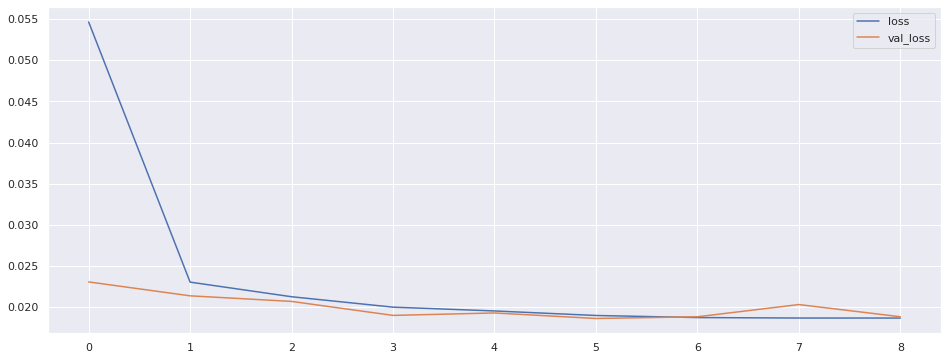

In [44]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [45]:
model.evaluate(X_test, y_test)

2509/2509 [==============================] - 35s 14ms/step - loss: 0.0181 - rad_mae: 22.8915


[0.01809602975845337, 22.89145278930664]

In [46]:
y_test.shape

(80267, 1)

In [47]:
y_predicted = model.predict(X_test)

In [48]:
YP = rad_scaler.denormalize(y_predicted)
YT = rad_scaler.denormalize(y_test)

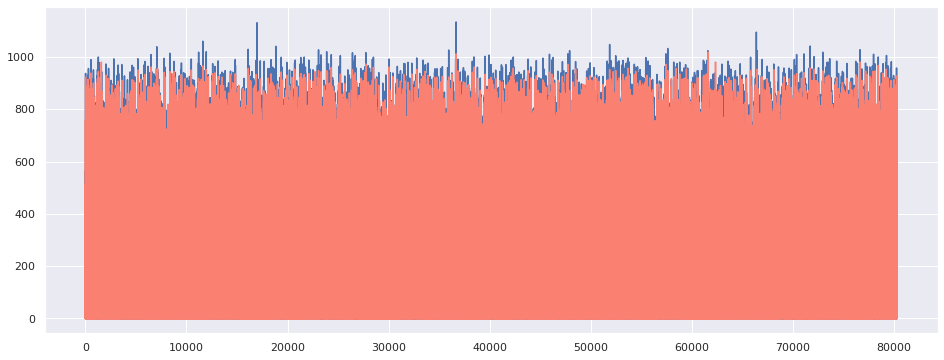

In [49]:
plt.plot(YT)
plt.plot(YP, color='salmon')
plt.show()

In [50]:
error = YT - YP

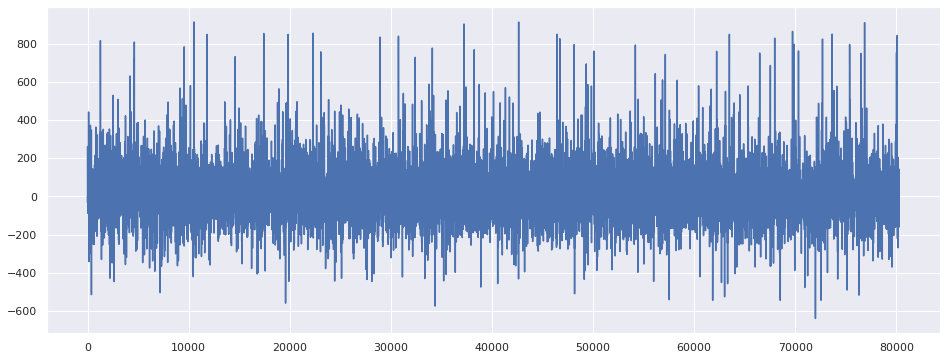

In [51]:
plt.plot(error)
plt.show()